# Project Title: Sales Predictions Model

- Author: Osmayda Nino

## Project Overview

This project will be a sales prediction for food items sold at various stores. The goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in increasing sales.

**Data Dictionary for this dataset**

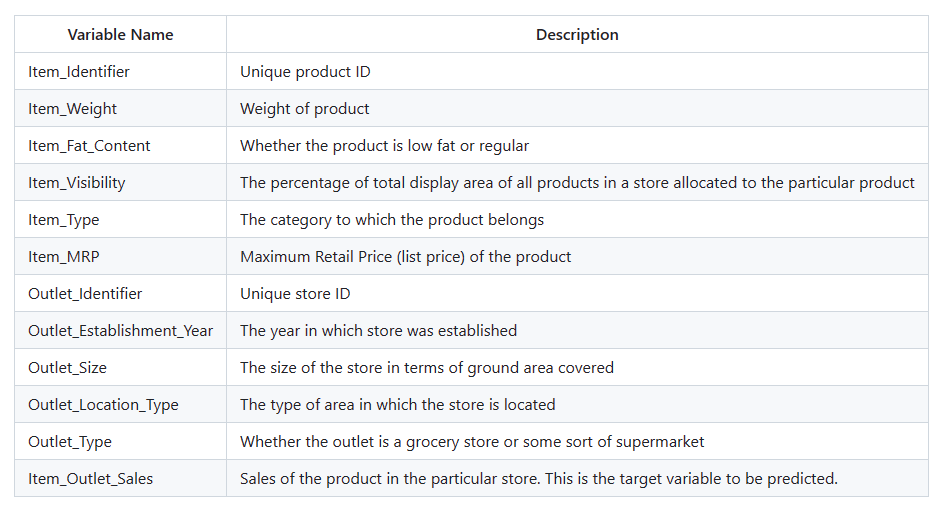

# Import Libraries | Load Data

## Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
price_fmt = StrMethodFormatter("${x:,.0f}")

import seaborn as sns
sns.set_style('white')

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree

set_config(display='diagram')

from IPython.core.display import clear_output

## Filter ALL warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\osmay\AppData\Local\Temp\ipykernel_8484\536455153.py:31: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output


# Custom Function

In [2]:
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING', figsize = (12,6), order = None):
    
    temp_df = df.copy()
    null_count = temp_df[x].isna().sum()
    null_perc = null_count/len(temp_df)* 100
    
    if fillna == True:
        temp_df[x] = temp_df[x].fillna(placeholder)
        
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.countplot(data=temp_df, x=x, ax=ax, order=order)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontweight = 'bold')
    ax.set_title(f'Column: {x}', fontsize = 18, fontweight = 'bold')
    ax.set_ylabel('Count', fontweight = 'bold', fontsize = 12)
    plt.xlabel(x, fontweight = 'bold', fontsize = 12)
    plt.xticks(fontsize = 10, fontweight = 'bold')
    plt.yticks(fontsize = 10, fontweight = 'bold');
    
    fig.tight_layout()
    plt.show()

In [3]:
## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics
def model_metrics(pipe, X_train, y_train, X_test, y_test,
                       model_name='Regression Model'):

  """Takes a regression model, training features and target and testing features and target.
  Returns a dataframe of regression metrics"""

  ## Predictions
  train_pred = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  metrics = ['train_MAE','test_MAE',
             'train_RMSE', 'test_RMSE',
             'train_R2', 'test_R2']

  ## Train
  train_mae = round(mean_absolute_error(y_train, train_pred),4)
  train_rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
  train_r2 = round(r2_score(y_train, train_pred),4)

  ## Test
  test_mae = round(mean_absolute_error(y_test, test_preds),4)
  test_rmse = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
  test_r2 = round(r2_score(y_test, test_preds),4)

  ## Output Dataframe
  scores = pd.DataFrame(columns=metrics, index=[f'{model_name}'])
  scores.loc[f'{model_name}', :] = [train_mae, test_mae,
                                          train_rmse, test_rmse,
                                          train_r2, test_r2]

  return scores

# Load Data

In [4]:
df = pd.read_csv("Data/sales_predictions_2023.csv") 

# Summary of the DataFrame's Columns and preview the first row of data 
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


# Clean Data

In [5]:
# The number  of rows and columns of the DataFrame
df.shape
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 8523 rows and 12 columns.
The rows represent 8523 observations and the columns represent 11 features and 1 target variable.


In [6]:
# The .dtype attribute returns a Series with the data type of each column
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

- The dataset has a combination of categorical (object) and numberic (float and int) data types.

## Remove Unnecessary Columns

In [7]:
# removing Item_Identifier - too many unique values
df.drop(columns = 'Item_Identifier', inplace = True)

## Duplicates

In [8]:
# Check data for duplicates
df.duplicated().sum()

0

- No duplicates found to be dropped. 

## Missing Values

In [9]:
# Identifing missing values
df.isna().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- Item_Weight and Outlet_Size have some missing(null) values. 

- **Item_Weight and the Outlet_Size are import information for retailer to understand how properties of products play crucial roles in increasing sales. Will handle null values next**

## Handling Null Values

### Cleaning Missing Item_Weight

- Item_Weight is a numerical value, we should be able to use mean, median, or mode to impute values.

 - will use median to impute values

In [10]:
# Impute average for Item_Weight
median_item_weight = df['Item_Weight'].median()
df['Item_Weight'].fillna(median_item_weight, inplace=True)

### Cleaning Missing Outlet_Size

- Outlet-Size is missing 2410 values out of 8523.

In [11]:
# Checking for unique values
pd.unique(df['Outlet_Size'])

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [12]:
# Missing values will be replaced with "missing" for Outlet_Size
df['Outlet_Size'].fillna("missing", inplace=True)

In [13]:
# Confirm there are no missing values after addressing them
df.isna().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Inspect Columns with Object Datatypes

- Check for common syntax errors which may include extra white spaces at the beginning or end of strings or column names.

- Check for typos or inconsistencies in strings that need to be fixed.

In [14]:
# Inspect column names for Errors
df.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales'],
      dtype='object')

In [15]:
# Checking for common syntax errors, typos, inconsistencies in strings that need to be fixed
# Create a series of the datatypes
data_types = df.dtypes
# Create a filter to select only the object datatypes
object_data_types = data_types[(data_types == 'object')]
# Display the series of object datatypes
object_data_types

Item_Fat_Content        object
Item_Type               object
Outlet_Identifier       object
Outlet_Size             object
Outlet_Location_Type    object
Outlet_Type             object
dtype: object

In [16]:
# Loop through the index of object_data_types
for column in object_data_types.index:
  print(column)
  print(df[column].unique())
  print('\n')

Item_Fat_Content
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']


Item_Type
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']


Outlet_Identifier
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']


Outlet_Size
['Medium' 'missing' 'High' 'Small']


Outlet_Location_Type
['Tier 1' 'Tier 3' 'Tier 2']


Outlet_Type
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']




#### Fixing inconsistencies with Item_Fat_Content

In [17]:
df.groupby(['Item_Fat_Content'])['Item_Fat_Content'].count()

Item_Fat_Content
LF          316
Low Fat    5089
Regular    2889
low fat     112
reg         117
Name: Item_Fat_Content, dtype: int64

- Replace 'LF' and 'low fat' with 'Low Fat'
- Replace 'reg' with 'Regular'

In [18]:
# Defining a dictionary with key/value pairs and using it to replace values
dict = {"low fat": 'Low Fat', "reg": 'Regular', "LF": 'Low Fat'}
df.replace({'Item_Fat_Content': dict}, inplace = True)

In [19]:
# Confirm Item_Fat_Content has been standardize
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## Inspect Columns with Numerical Datatypes

- Filter columns with numerical indexes to obtain summary statistics (min, max, mean).

In [20]:
# Summary statistics for Numeric Columns
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.00000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.81342,0.066132,140.992782,1997.831867,2181.288914
std,4.22724,0.051598,62.275067,8.371760,1706.499616
min,4.55500,0.000000,31.290000,1985.000000,33.290000
25%,9.31000,0.026989,93.826500,1987.000000,834.247400
50%,12.60000,0.053931,143.012800,1999.000000,1794.331000
75%,16.00000,0.094585,185.643700,2004.000000,3101.296400
max,21.35000,0.328391,266.888400,2009.000000,13086.964800


- No unusual statistics noted. 

# Exploratory Data Analysis

## Numerical Columns

In [21]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.00000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.81342,0.066132,140.992782,1997.831867,2181.288914
std,4.22724,0.051598,62.275067,8.371760,1706.499616
min,4.55500,0.000000,31.290000,1985.000000,33.290000
25%,9.31000,0.026989,93.826500,1987.000000,834.247400
50%,12.60000,0.053931,143.012800,1999.000000,1794.331000
75%,16.00000,0.094585,185.643700,2004.000000,3101.296400
max,21.35000,0.328391,266.888400,2009.000000,13086.964800


### Histogram

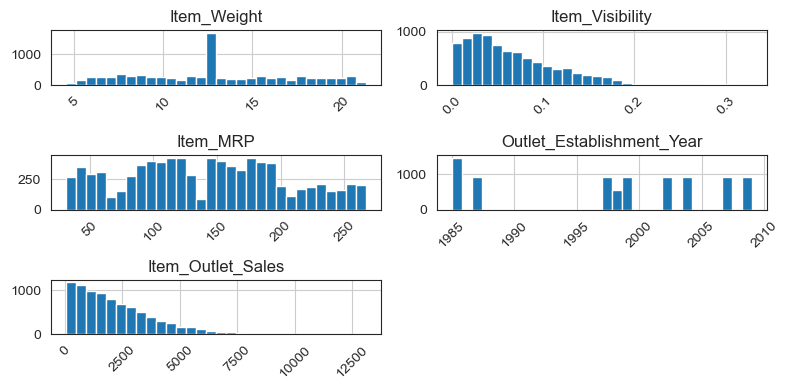

In [22]:
# Hitograms to view the distributions of numerical features
df.hist(figsize=(8,4), xrot=45, bins=30)
plt.tight_layout()
plt.show;

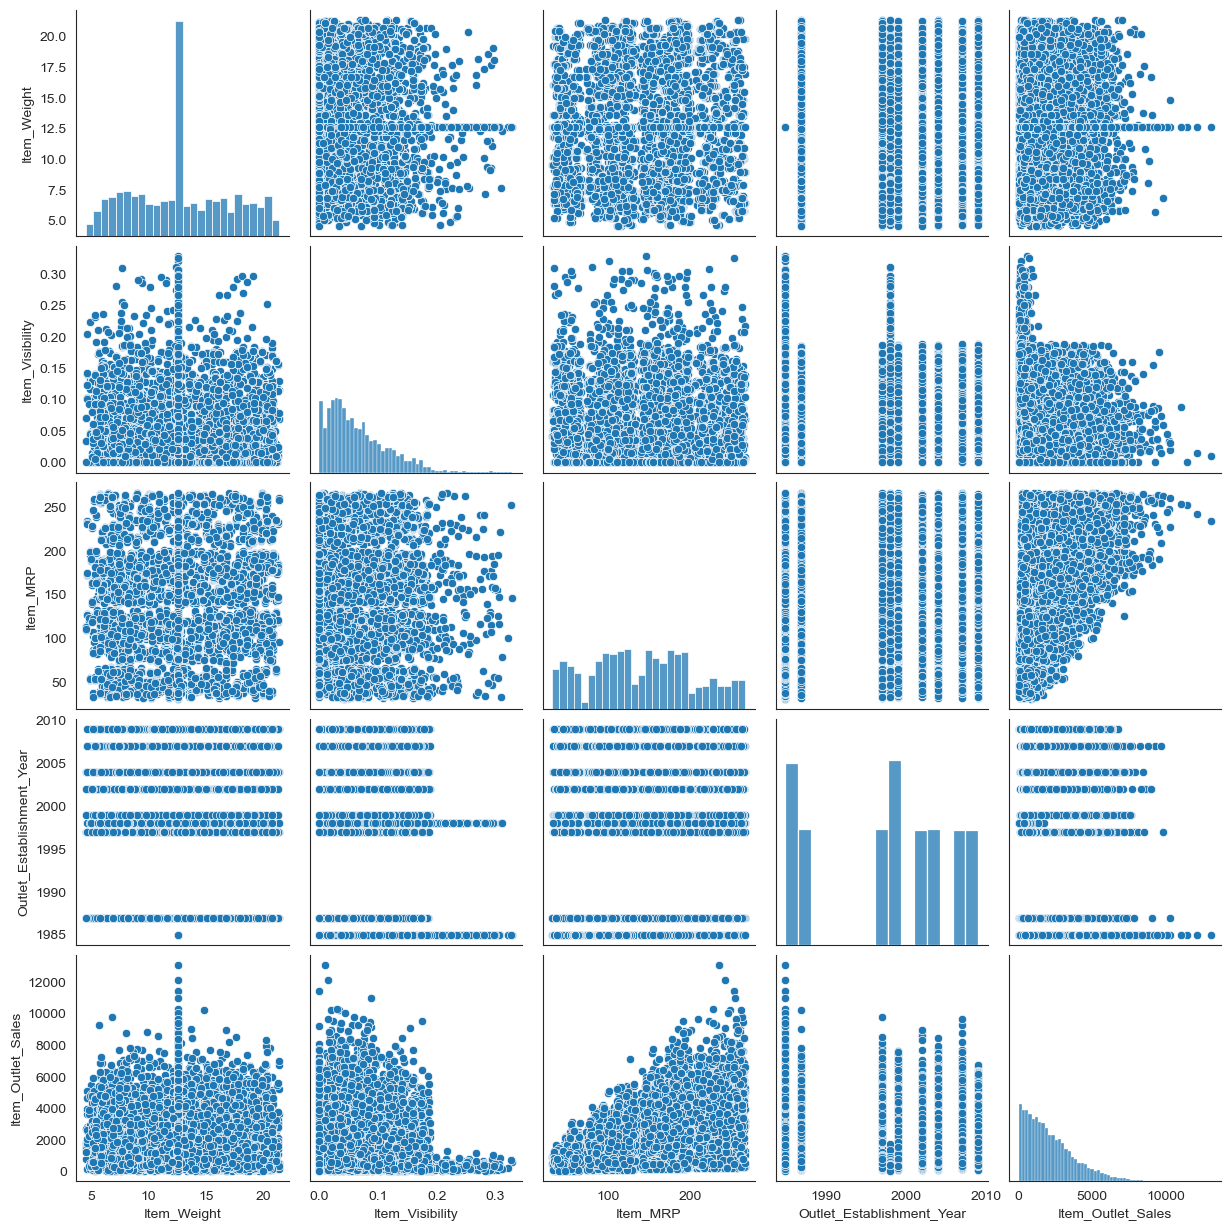

In [23]:
sns.pairplot(df, vars = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']);

### Boxplots 

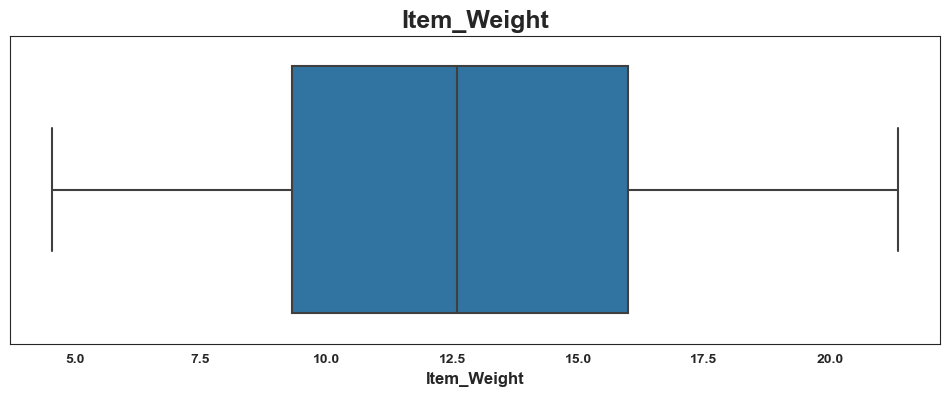

In [24]:
plt.figure(figsize = (12,4))

# boxplot using seaborn - Item_Weight
ax = sns.boxplot(x = 'Item_Weight', data = df)

# customize boxplot
ax.set_title('Item_Weight', fontsize = 18, weight='bold')
plt.xlabel('Item_Weight', weight = 'bold', fontsize = 12)
plt.xticks(fontsize = 10, weight = 'bold');

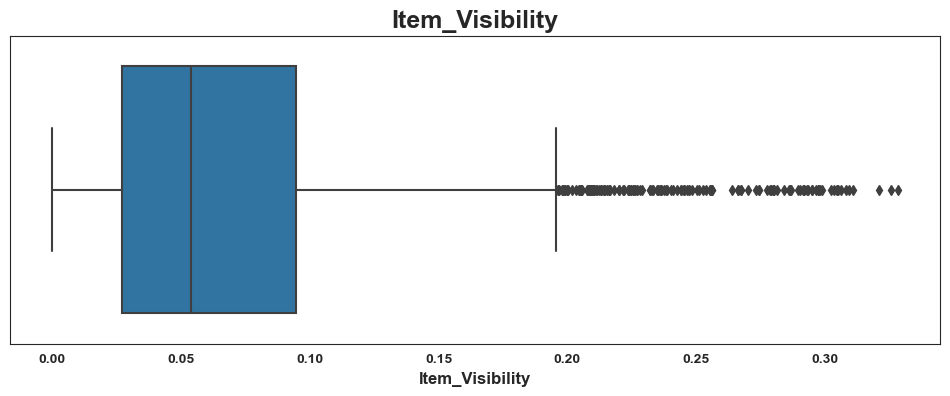

In [25]:
plt.figure(figsize = (12,4))

# boxplot using seaborn - Item_Visibility
ax = sns.boxplot(x = 'Item_Visibility', data = df)

# customize boxplot
ax.set_title('Item_Visibility', fontsize = 18, weight='bold')
plt.xlabel('Item_Visibility', weight = 'bold', fontsize = 12)
plt.xticks(fontsize = 10, weight = 'bold');

- Item_Visibility has many outliers

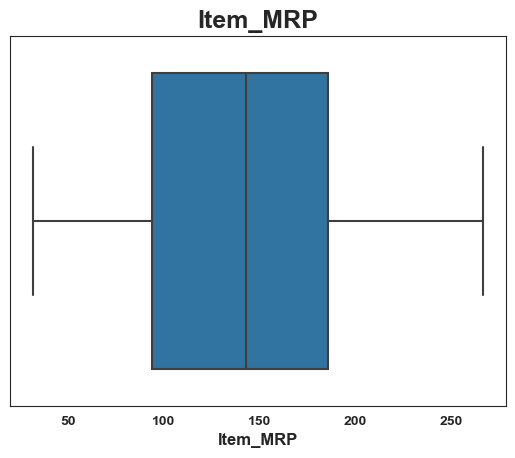

In [26]:
# boxplot using seaborn - Item_MRP
ax = sns.boxplot(x = 'Item_MRP', data = df)

# customize boxplot
ax.set_title('Item_MRP', fontsize = 18, weight='bold')
plt.xlabel('Item_MRP', weight = 'bold', fontsize = 12)
plt.xticks(fontsize = 10, weight = 'bold');

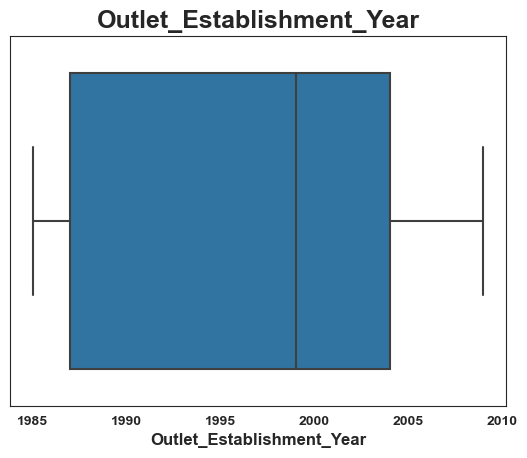

In [27]:
# boxplot using seaborn - Outlet_Establishment_Year
ax = sns.boxplot(x = 'Outlet_Establishment_Year', data = df)

# customize boxplot
ax.set_title('Outlet_Establishment_Year', fontsize = 18, weight='bold')
plt.xlabel('Outlet_Establishment_Year', weight = 'bold', fontsize = 12)
plt.xticks(fontsize = 10, weight = 'bold');

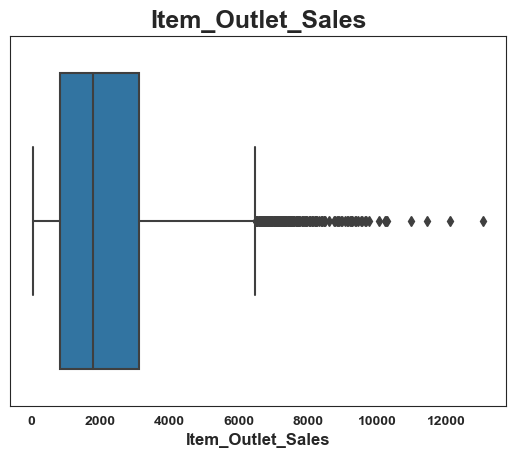

In [28]:
# boxplot using seaborn - Item_Outlet_Sales
ax = sns.boxplot(x = 'Item_Outlet_Sales', data = df)

# customize boxplot
ax.set_title('Item_Outlet_Sales', fontsize = 18, weight='bold')
plt.xlabel('Item_Outlet_Sales', weight = 'bold', fontsize = 12)
plt.xticks(fontsize = 10, weight = 'bold');

- Item_Outlet_Sales has many outliers.

## Categorical Columns

In [29]:
df.describe(exclude='number')

,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,8523,8523
unique,2,16,10,4,3,4
top,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,5517,1232,935,2793,3350,5577


### Item Fat Content

In [30]:
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

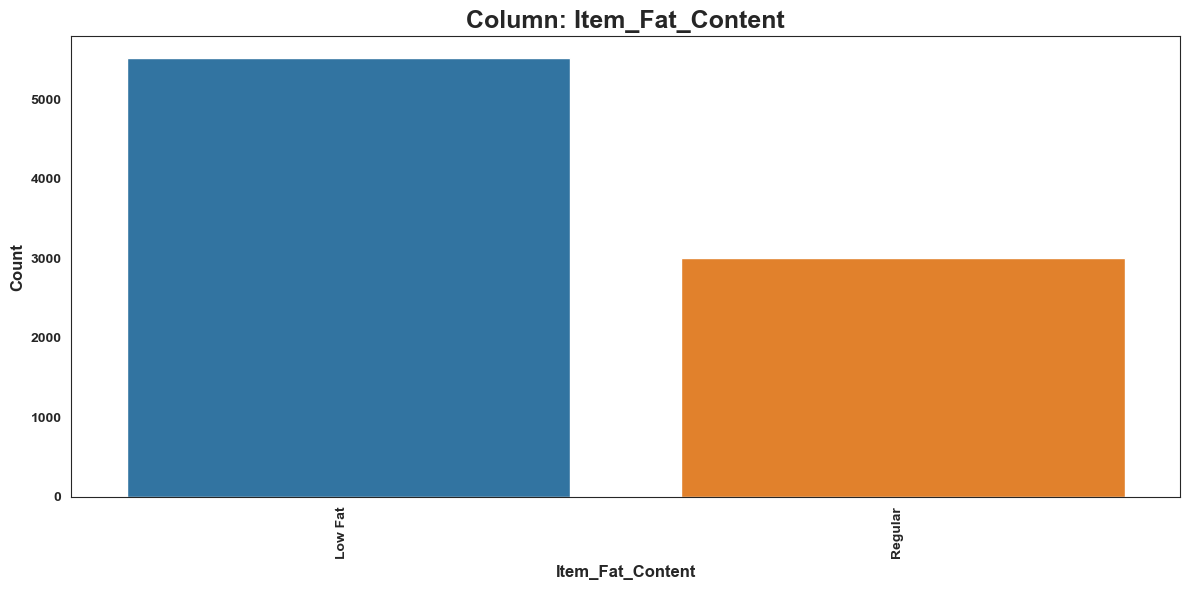

In [31]:
# exploring categorical columns 
explore_categorical(df, 'Item_Fat_Content')

- Item_Fat_Content is categorical nominal

### Item_Type

In [32]:
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

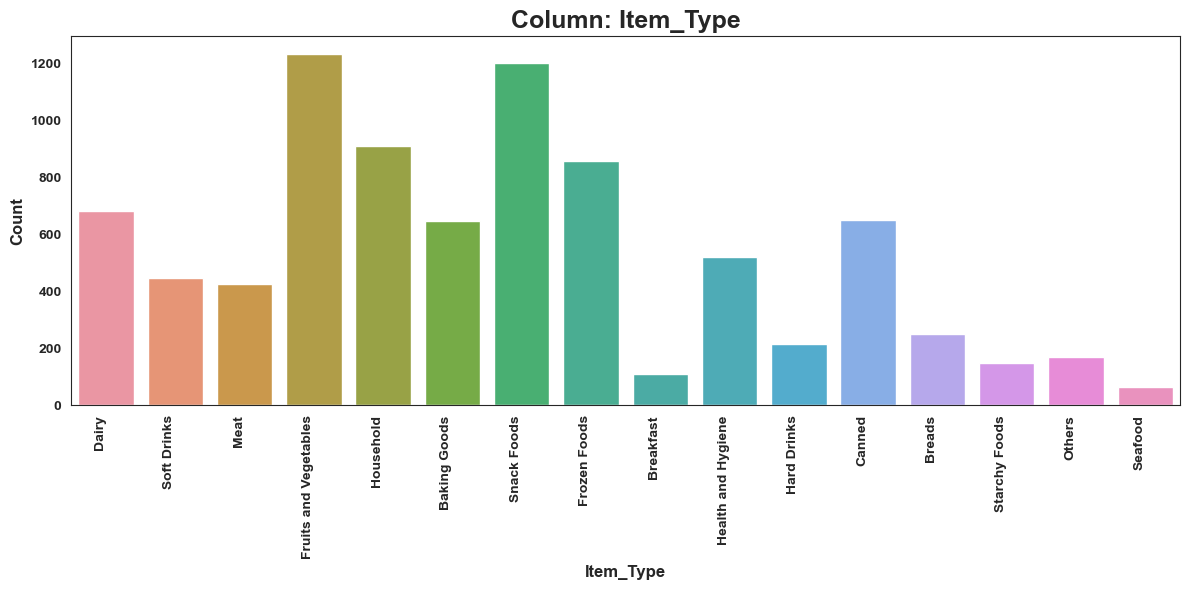

In [33]:
#exploring categorical columns 
explore_categorical(df, 'Item_Type')

- Item_Type is categorical nominal
- cardinality is high (>10)

### Outlet_Identifier

In [34]:
df['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

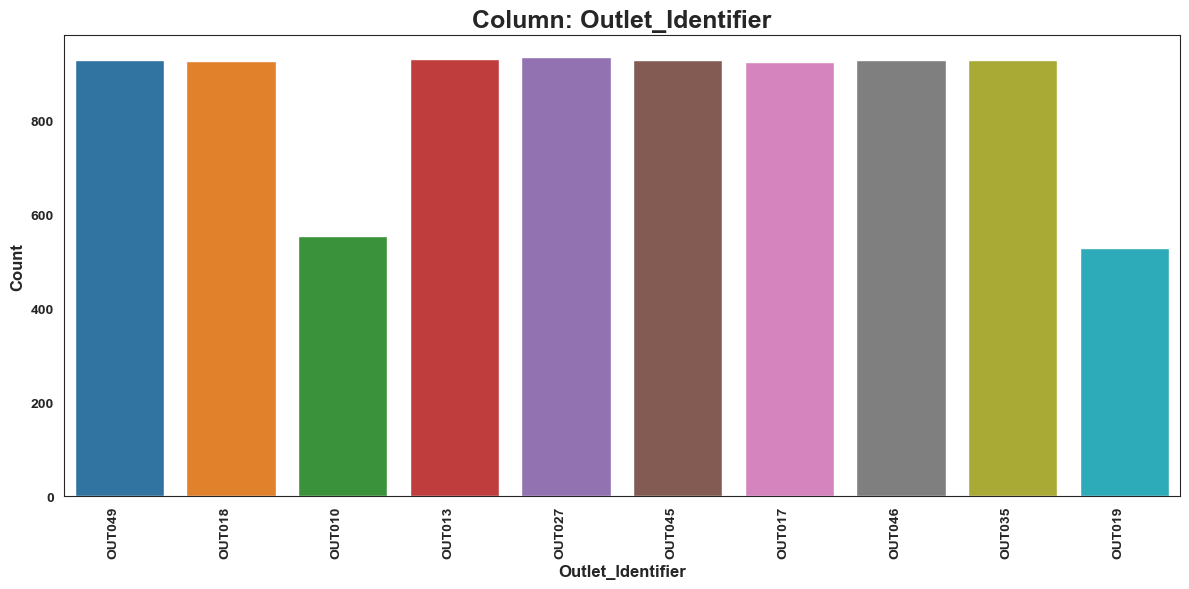

In [35]:
#exploring categorical columns
explore_categorical(df, 'Outlet_Identifier')

- Outlet_identifier is categorical nominal
- cardinality is high (>10)

### Outlet_Size

In [36]:
df['Outlet_Size'].value_counts()

Medium     2793
missing    2410
Small      2388
High        932
Name: Outlet_Size, dtype: int64

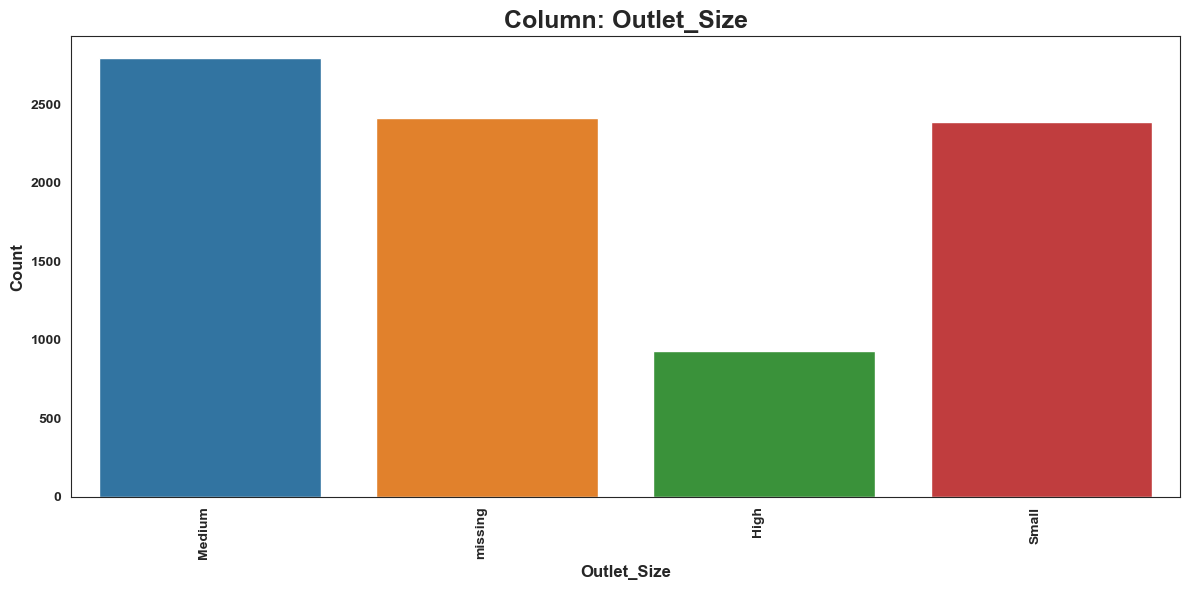

In [37]:
#exploring categorical columns
explore_categorical(df, 'Outlet_Size')

- Outllet_Size is categorical ordinal

### Outlet_Location_Type

In [38]:
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

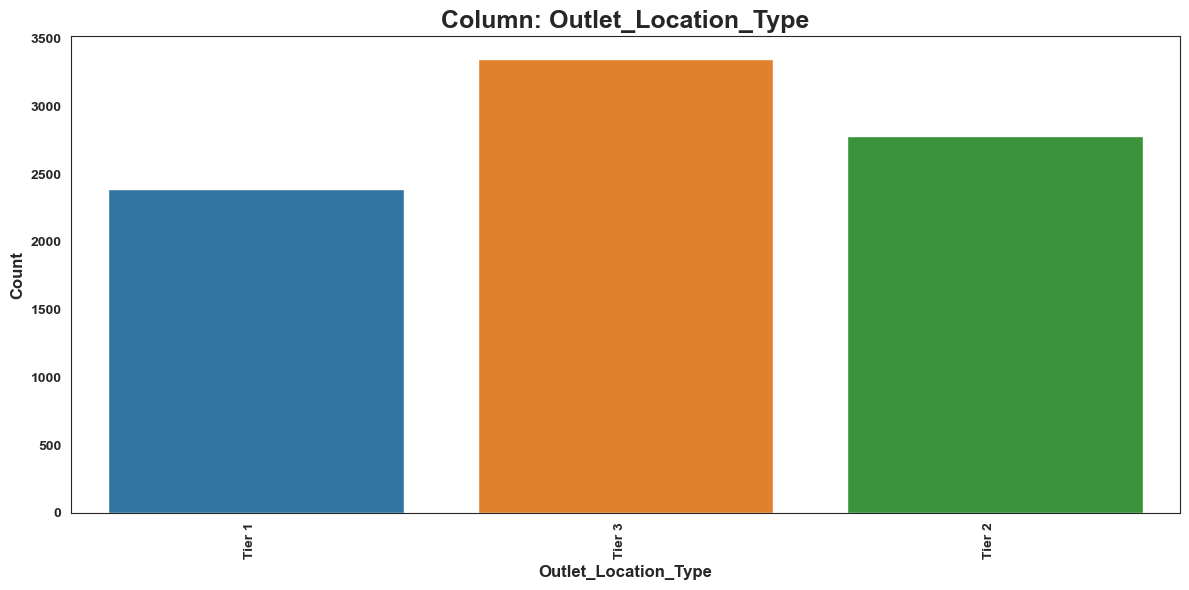

In [39]:
#exploring categorical columns
explore_categorical(df, 'Outlet_Location_Type')

- Outlet_Location_Type is categorical nominal

### Outlet_Type

In [40]:
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

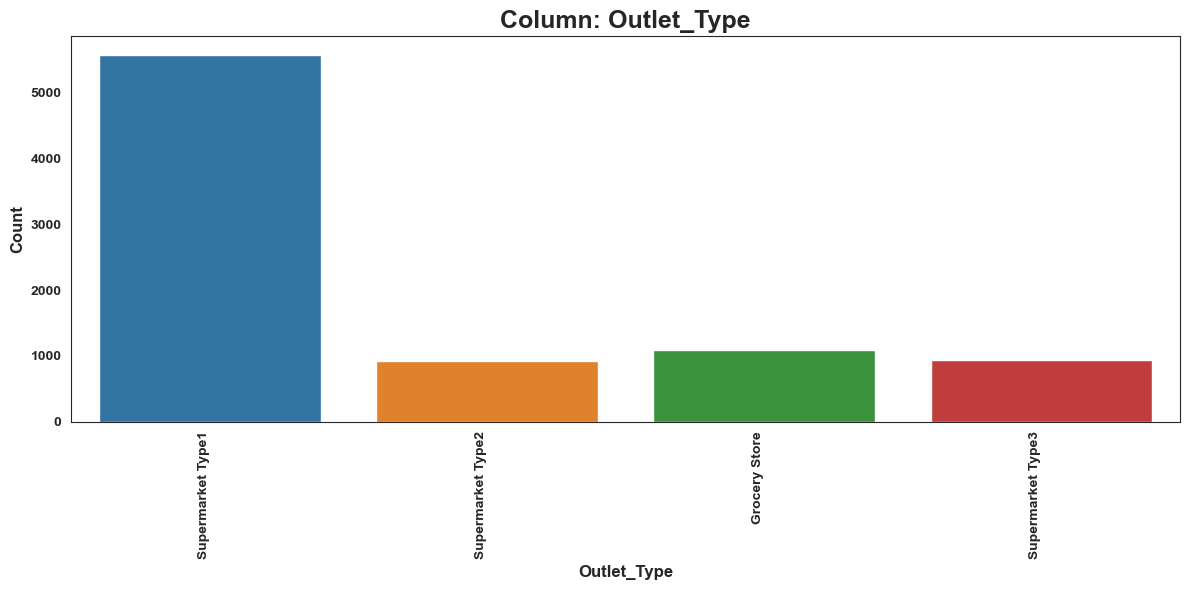

In [41]:
#exploring categorical columns using seaborn
explore_categorical(df, 'Outlet_Type')

- Outlet_Type is categorical nominal

## Correlation Heatmap

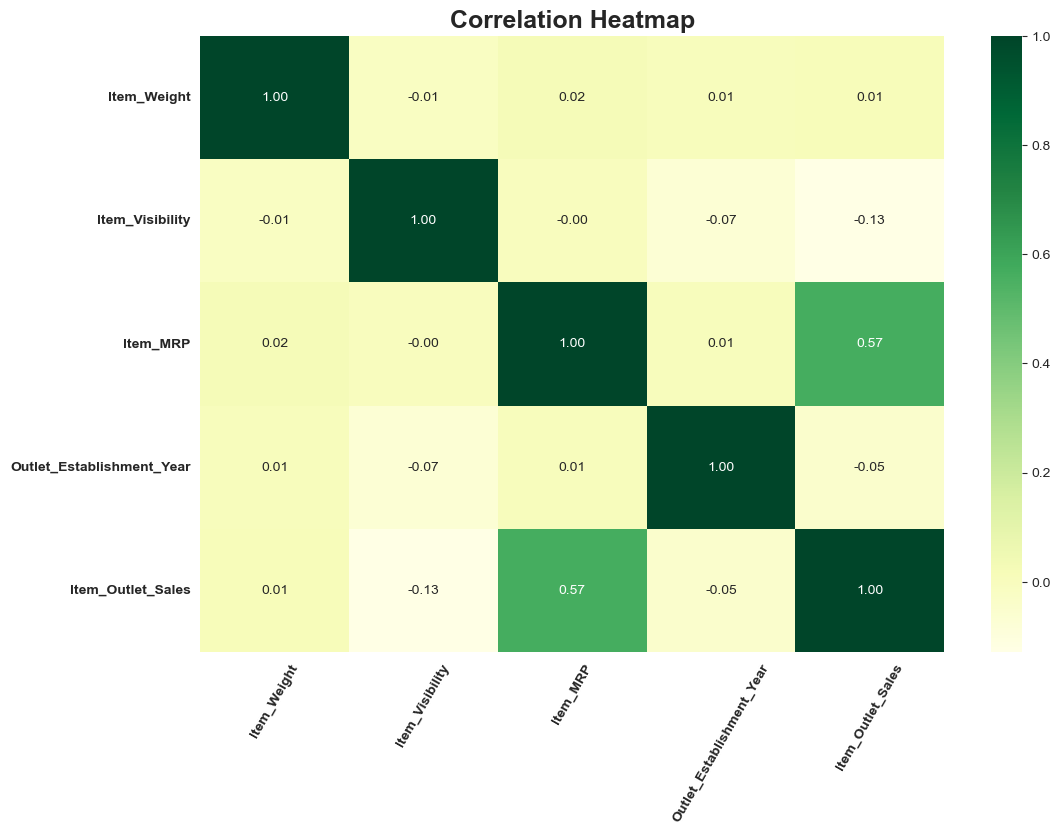

In [42]:
fig, ax = plt.subplots(figsize = (12, 8))

corr = df.corr()

ax = sns.heatmap(corr, cmap= 'YlGn', annot = True, fmt = '.2f')
plt.title('Correlation Heatmap', fontsize = 18, weight = 'bold')
plt.xticks(fontsize = 10, weight = 'bold', rotation = 60)
plt.yticks(fontsize = 10, weight = 'bold');

- Item_MRP and Item_Visibility have the highestes correlation to Item_Outlet_Sales.

# Explanatory Data Analysis

- **Item_MRP** and **Item_Outlet_Sales** have a moderate positive correlation of 0.57

In [43]:
# Display the first (5) rows of the dataframe
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,missing,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


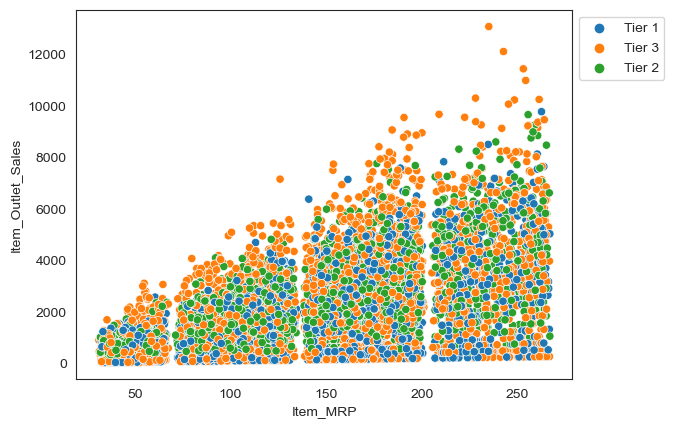

In [44]:
ax = sns.scatterplot(data = df, x = 'Item_MRP', y = 'Item_Outlet_Sales', hue = 'Outlet_Location_Type');
ax.legend(bbox_to_anchor = [1, 1]);

- Item_MRP has a positive correlation to Item_Outlet Sales. 

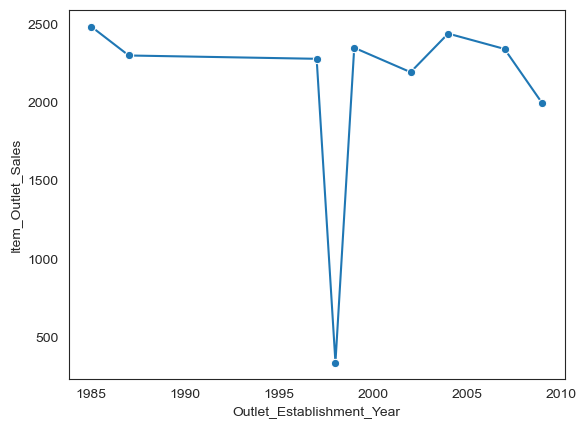

In [45]:
sns.lineplot(data = df, x = 'Outlet_Establishment_Year', y = 'Item_Outlet_Sales', errorbar = None, marker = 'o');

    - Sales appear to be mostly trending down around 2004. 

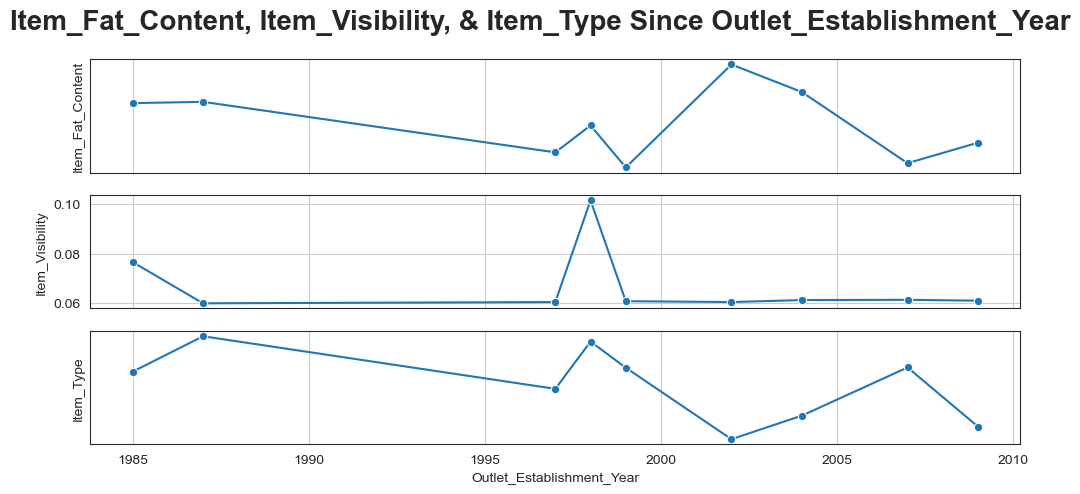

In [46]:
## Define MatplotLib fig and ax objects using plt.subplots()
fig, axes = plt.subplots(nrows = 3, figsize = (12,5), sharex = True)

sns.lineplot(data = df, x = 'Outlet_Establishment_Year', y = 'Item_Fat_Content', errorbar = None, marker = 'o', ax = axes[0])
sns.lineplot(data = df, x = 'Outlet_Establishment_Year', y = 'Item_Visibility', errorbar = None, marker = 'o', ax = axes[1])
sns.lineplot(data = df, x = 'Outlet_Establishment_Year', y = 'Item_Type', errorbar = None, marker = 'o', ax = axes[2])

# list comprehension
[ax.grid() for ax in axes]

## Set the Suptitle
fig.suptitle('Item_Fat_Content, Item_Visibility, & Item_Type Since Outlet_Establishment_Year', fontsize = 20, fontweight = 'bold');

- Low fat or regular products started increasing in sale around 2007. 
- Display area of all products in a store is fairly constant.

# Preprocessing for Machine Learning

## Load Data

In [47]:
# Load in the data
df = pd.read_csv("Data/sales_predictions_2023.csv") 

# Summary of the DataFrame's Columns and preview the first row of data 
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


# Clean Data

- Checking for duplicated, missing, or erroneous data

In [48]:
# removing Item_Identifier - too many unique values
df.drop(columns = 'Item_Identifier', inplace = True)

In [49]:
# Check data for duplicates
df.duplicated().sum()

0

In [50]:
# Identifing missing values
df.isna().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- Fixing inconsistencies in categorical data: will standardize Item_Fat_ Content 

In [51]:
# Defining a dictionary with key/value pairs and using it to replace values
dict = {"low fat": 'Low Fat', "reg": 'Regular', "LF": 'Low Fat'}
df.replace({'Item_Fat_Content': dict}, inplace = True)

In [52]:
# Confirm Item_Fat_Content has been standardize
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [53]:
# Display descriptive statistics
df.describe(include='number')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [54]:
# Display descriptive statistics
df.describe(include='object')

,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,6113,8523,8523
unique,2,16,10,3,3,4
top,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,5517,1232,935,2793,3350,5577


# Identify the Features and Target

- Target: Item_Outlet_Sales
- Features: all other columns

In [55]:
# Check target for null values
df['Item_Outlet_Sales'].isna().sum()

0

In [56]:
# Make a copy of the clean df
eda_ml = df.copy()

# Split the Data (Validation Split)

In [57]:
# split X and y
X = eda_ml.drop(columns=['Item_Outlet_Sales']).copy()
y = eda_ml['Item_Outlet_Sales'].copy()

# split training and test
# set random_state to 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30 , random_state=42)

In [58]:
# this is to check that the dataset was split (selected test_size=.30, so train data is split into 70% and test data is 30%)
X_train.shape

(5966, 10)

In [59]:
X_test.shape

(2557, 10)

# Preprocessing

## Numeric Pipelines

In [60]:
# Transformers
mean_imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Pipeline
num_pipeline = make_pipeline(mean_imputer, scaler)

# Selector
num_selector = make_column_selector(dtype_include='number')

# Tuple
numeric_tuple = (num_pipeline, num_selector)

## Categorical Pipelines

In [61]:
# Transformers
missing_imputer = SimpleImputer(strategy='constant', fill_value='missing')
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Pipeline
cat_pipeline = make_pipeline(missing_imputer, ohe)

# Selector
cat_selector = make_column_selector(dtype_include='object')

# Tuple
cat_tuple = (cat_pipeline, cat_selector)

## Column Transformer to Apply Different Preprocessing to Different Columns

In [62]:
# Instantiate the make column transformer
preprocessor = make_column_transformer(numeric_tuple,
                                       cat_tuple,
                                       remainder='drop', verbose_feature_names_out=False)

# Linear Regression Model

In [63]:
## Create an instance of the model
lin_reg = LinearRegression()

## Create a model pipeline
lin_reg_pipe = make_pipeline(preprocessor, lin_reg)

## Fit the model
lin_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD255AB5E0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD255ABD30>)],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

## Metrics

In [64]:
## Display the Model's metrics
scores_df = model_metrics(lin_reg_pipe, X_train=X_train, y_train=y_train,
                          X_test=X_test, y_test=y_test,
                          model_name='Linear Regression Model')

display(scores_df)

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Linear Regression Model,847.6681,810.4079,1139.5933,1100.1589,0.5609,0.5679


# Hight Variance Decision Tree Model

In [65]:
## Create an instance of the model
dec_tree = DecisionTreeRegressor(max_depth=None, random_state = 42)

## Create a model pipeline
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)

## Fit the model
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD255AB5E0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD255ABD30>)],
                                   verbose_feature_names_out=False)),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

## Metrics

In [66]:
## Display the Model's metrics
scores_high_dt = model_metrics(dec_tree_pipe, X_train=X_train, y_train=y_train,
                          X_test=X_test, y_test=y_test,
                          model_name='High Variance Decision Tree Model')

scores_df = pd.concat([scores_df, scores_high_dt])
display(scores_df)

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Linear Regression Model,847.6681,810.4079,1139.5933,1100.1589,0.5609,0.5679
High Variance Decision Tree Model,0.0,1061.1644,0.0,1523.1393,1.0,0.1717


In [67]:
## Display the list of available hyperparameters for tuning
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [68]:
## Obtain the max_depth from the pipeline 
max_depth = dec_tree_pipe['decisiontreeregressor'].get_depth()
## Display max_depth
max_depth

40

# High Bias Decision Tree Model

In [69]:
## Create an instance of the model
dec_tree = DecisionTreeRegressor(max_depth=1, random_state = 42)
## Create a model pipeline
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
## Fit the model
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD255AB5E0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD255ABD30>)],
                                   verbose_feature_names_out=False)),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=1, random_state=42))])

## Metrics

In [70]:
## Display the Model's metrics
bias_scores = model_metrics(dec_tree_pipe, X_train=X_train, y_train=y_train,
                            X_test=X_test, y_test=y_test,
                            model_name='Shallow Decision Tree Model')

scores_df = pd.concat([scores_df, bias_scores])
display(scores_df)

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Linear Regression Model,847.6681,810.4079,1139.5933,1100.1589,0.5609,0.5679
High Variance Decision Tree Model,0.0,1061.1644,0.0,1523.1393,1.0,0.1717
Shallow Decision Tree Model,1137.1108,1119.4787,1502.0473,1464.8475,0.2371,0.2339


In [71]:
## Display the list of available hyperparameters for tuning
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

# Bias Variance Tuned Version

In [72]:
## Create a range of values from 1 to max_depth to evaluate
depths = range(1, max_depth+1)

## Create a dataframe to store Train and Test  R2 scores
scores = pd.DataFrame(columns=['Train R2', 'Test R2'], index=depths)

## Loop through the max_depth values
for depth in depths:
  # progress checker
  clear_output(wait=True)
  print(f'testing depth of {depth} of {max_depth}')

  ## Create an instance of the model
  dec_tree = DecisionTreeRegressor(max_depth=depth, random_state = 42)
  ## Create a model pipeline
  dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
  ## Fit the model
  dec_tree_pipe.fit(X_train, y_train)

  ## Obtain the predictions from the model
  train_pred = dec_tree_pipe.predict(X_train)
  test_pred = dec_tree_pipe.predict(X_test)

  ## Obtain the R2 scores for Train and Test
  train_r2score = r2_score(y_train, train_pred)
  test_r2score = r2_score(y_test, test_pred)

  ## Save the Train and Test R2 Score for this depth in the scores dataframe
  scores.loc[depth, 'Train R2'] = train_r2score
  scores.loc[depth, 'Test R2'] = test_r2score

testing depth of 40 of 40


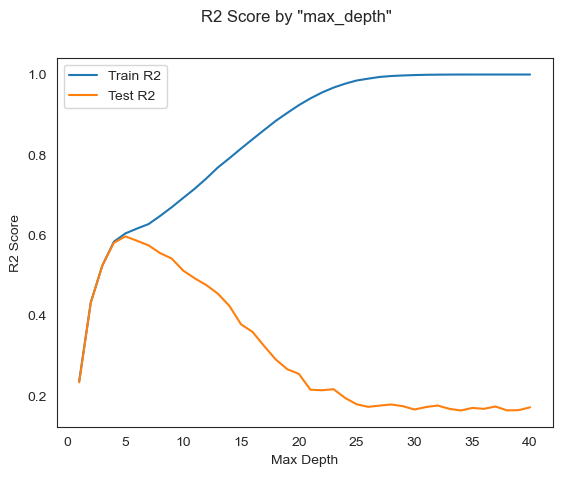

In [73]:
##Visualize the max_depths to display which achieves the highest R2 score
plt.plot(depths, scores['Train R2'], label='Train R2')
plt.plot(depths, scores['Test R2'], label='Test R2')
plt.ylabel('R2 Score')
plt.xlabel('Max Depth')
plt.suptitle('R2 Score by "max_depth"')
plt.legend()
plt.show()

In [74]:
## Create a version on the scores dataframe
## sorted by highest Test Scores
sorted_scores = scores.sort_values(by='Test R2', ascending=False)
## Display the first (5) rows of the dataframe
sorted_scores.head()

,Train R2,Test R2
5,0.604615,0.597148
6,0.616611,0.586225
4,0.583913,0.581257
7,0.6278,0.574755
8,0.648006,0.555486


In [75]:
## sort the dataframe by test scores and save the index (k) of the best score
best_depth = sorted_scores.index[0]
best_depth

5

In [76]:
## Create an instance of the model
dec_tree = DecisionTreeRegressor(max_depth=best_depth, random_state = 42)
## Create a model pipeline
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
## Fit the model
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD255AB5E0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD255ABD30>)],
                                   verbose_feature_names_out=False)),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, random_state=42))])

In [77]:
## Display the Model's metrics
tuned_DT_scores = model_metrics(dec_tree_pipe, X_train=X_train, y_train=y_train,
                                X_test=X_test, y_test=y_test,
                                model_name='Tuned Decision Tree Model')

scores_df = pd.concat([scores_df, tuned_DT_scores])

display(scores_df)

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Linear Regression Model,847.6681,810.4079,1139.5933,1100.1589,0.5609,0.5679
High Variance Decision Tree Model,0.0,1061.1644,0.0,1523.1393,1.0,0.1717
Shallow Decision Tree Model,1137.1108,1119.4787,1502.0473,1464.8475,0.2371,0.2339
Tuned Decision Tree Model,760.8905,743.535,1081.3531,1062.2545,0.6046,0.5971


# Model Comparison

In [78]:
display(scores_df)

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Linear Regression Model,847.6681,810.4079,1139.5933,1100.1589,0.5609,0.5679
High Variance Decision Tree Model,0.0,1061.1644,0.0,1523.1393,1.0,0.1717
Shallow Decision Tree Model,1137.1108,1119.4787,1502.0473,1464.8475,0.2371,0.2339
Tuned Decision Tree Model,760.8905,743.535,1081.3531,1062.2545,0.6046,0.5971


R^2 (Coefficient of Determination)
- The Tuned Decision Tree Model has the highest R^2 test score of 0.5971.

RMSE (Root Mean Square of Errors)
- The Tuned Decision Tree Model has the lowest RMSE test score of 1081.3531

**The Tuned Decision Tree Model is the reccomended model due to it having the highest R^2 test score and the lowest RMSE test score.**